# vcc792_bin.ipynb

### Isaac Cheng - September 2021

Various plots of VCC 792 with binning. Read [this webpage](http://www.cadc-ccda.hia-iha.nrc-cnrc.gc.ca/en/community/ngvs/docs/ngvsdoc.html) for lots of useful information! Also look at [this PDF](https://www.ucolick.org/~bolte/AY257/s_n.pdf) for a useful overview of CCD signal/noise satistics. Also read the section on binning.

Also: [Astropy Course](https://www.iasf-milano.inaf.it/astropy-course/), in particular, see the [Astropy image walkthrough](https://www.iasf-milano.inaf.it/AstropyCourse/07.Images.slides.html).

[vorbin manual](https://www-astro.physics.ox.ac.uk/~mxc/software/vorbin_manual.pdf) and [Michele Cappellari's Python Programs page](http://www-astro.physics.ox.ac.uk/~mxc/software/)

### Current Goals

- Display voronoi binned data without using built-in function?
  - For major axis profile
  - To see pixelation
  - Likely will need to adapt `vorbin` to return more variables.
- Use RA & Dec to display coordinates of binned images


In [1]:
# # May need to do this if running remote server with VS Code
%cd "/arc/home/IsaacCheng/coop_f2021/warmup"

/arc/home/IsaacCheng/coop_f2021/warmup


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import astropy.units as u
from astropy.wcs import WCS
from astropy.nddata import block_reduce
import vorbin
from vorbin.voronoi_2d_binning import voronoi_2d_binning
import plotbin
import fits_plot_utils as utils
from reproject import reproject_interp, reproject_exact
%matplotlib widget

# Voronoi Binning


In [3]:
# 
# Load data
# 
vcc792_dist = 16.5 * u.Mpc
# Signal
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# Noise (sigma maps)
inoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits"
gnoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_6905_10184.fits"
unoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.sig.3136_8588_6905_10184.fits"
# 
# Load NGVS data
# 
# Signal
data_i, header_i = utils.load_img(iband_path)
data_g, header_g = utils.load_img(gband_path)
data_u, header_u = utils.load_img(uband_path)
# Noise
noise_i, header_noise_i = utils.load_img(inoise_path)
noise_g, header_noise_g = utils.load_img(gnoise_path)
noise_u, header_noise_u = utils.load_img(unoise_path)
# 
# Cut out galaxy
# 
vcc792_center = (2716, 1613)
vcc792_shape = (1480, 1127)
data_i_cut, wcs_i_cut = utils.cutout(data_i, vcc792_center, vcc792_shape, header=header_i)
data_g_cut, wcs_g_cut = utils.cutout(data_g, vcc792_center, vcc792_shape, header=header_g)
data_u_cut, wcs_u_cut = utils.cutout(data_u, vcc792_center, vcc792_shape, header=header_u)
noise_i_cut, wcs_noise_i_cut = utils.cutout(noise_i, vcc792_center, vcc792_shape, header=header_noise_i)
noise_g_cut, wcs_noise_g_cut = utils.cutout(noise_g, vcc792_center, vcc792_shape, header=header_noise_g)
noise_u_cut, wcs_noise_u_cut = utils.cutout(noise_u, vcc792_center, vcc792_shape, header=header_noise_u)
# 
# VERTICO CO Data
# 
# co_path = "/arc/projects/vertico/products/release.v1.2/native/NGC4380/NGC4380_7m+tp_co21_pbcorr_round_k_mom0_Msun.fits"
co_path = "/arc/projects/vertico/products/release.v1.2/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_round_k_nyquistPix_9_arcsec_mom0_Msun.fits"
data_co, header_co = utils.load_img(co_path)

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      22   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_690

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


In [3]:
def calc_colour_err(blue, red, blue_err, red_err):
    """
    Calculates the uncertainty in the colour index using basic uncertainty propagation.
    The colour, or colour index, is defined as:
                        colour = -2.5 * log10(blue / red)
    where blue is the flux in the shorter wavelength band and red is the flux in the
    longer wavelength band.
    The uncertainty, assuming independent errors and to a first-order approximation, is
    given by:
            colour_err^2 = (-2.5/ln(10) * 1/blue)^2 * blue_err^2 +
                           (+2.5/ln(10) * 1/red)^2 * red_err^2
                         = (2.5/ln(10))^2 * [(blue_err/blue)^2 + (red_err/red)^2]
    Thus:
            colour_err = sqrt(colour_err^2)
                       = 2.5 / ln(10) * sqrt((blue_err/blue)^2 + (red_err/red)^2)
    Note that all the parameters MUST be able to broadcast together.

    Parameters:
      blue :: array
        The flux in the shorter wavelength band
      red :: array
        The flux in the longer wavelength band
      blue_err :: array
        The uncertainty in the flux in the shorter wavelength band
      red_err :: array
        The uncertainty in the flux in the longer wavelength band
        
    Returns: colour_err
      colour_err :: array
        The uncertainty in the colour index.
    """
    prefactor = 2.5 / np.log(10)
    errs = np.sqrt((blue_err / blue) ** 2 + (red_err / red) ** 2)
    return prefactor * errs


def prelim_bin(signal, noise, block_size=(4, 4), print_info=True):
    """
    Regular preliminary binning of 2D data (i.e., for Voronoi binning).
    
    (From astropy's block_reduce() documentation): If the data are not perfectly divisible
    by block_size along a given axis, then the data will be trimmed (from the end) along
    that axis.

    TODO: finish docstring
    """
    # Add signal array using arithmetic sum
    signal_binned = block_reduce(signal, block_size=block_size)
    # Add noise array in quadrature
    noise_binned = noise * noise
    noise_binned = block_reduce(noise_binned, block_size=block_size)
    noise_binned = np.sqrt(noise_binned)
    # 
    # Generate pixel coordinates
    # 
    y_coords, x_coords = np.meshgrid(
        np.arange(signal_binned.shape[0]), np.arange(signal_binned.shape[1])
    )
    x_coords, y_coords = x_coords.T, y_coords.T
    # 
    # Ensure no infs or NaNs in binned data (for Voronoi binning)
    # 
    is_good = np.isfinite(signal_binned) & np.isfinite(noise_binned)
    # 
    if print_info:
        print("x_coords, y_coords, signal_binned, noise_binned shapes:",
              x_coords.shape, y_coords.shape, signal_binned.shape, noise_binned.shape)
        print("total bad elements:", np.sum(~is_good))
    # 
    return signal_binned, noise_binned, x_coords, y_coords, is_good


def optimal_sn(index, signal, noise):
    """
    Signal-to-noise ratio approximation using optimal weighing of pixels.

    See Eq. (3) of Cappellari & Copin (2003):
    https://ui.adsabs.harvard.edu/abs/2003MNRAS.342..345C/abstract
    
    Parameters: (nearly verbatim from Cappellari & Copin's voronoi_2d_binning.py)
      index :: 1D array
        Integer vector of length N containing the indices of
        the spaxels for which the combined S/N has to be returned.
        The indices refer to elements of the vectors signal and noise.
      signal :: 1D array
        Vector of length M>N with the signal of all spaxels.
      noise :: 1D array
        Vector of length M>N with the noise of all spaxels.
    
    Returns: sn
      sn :: 1D array
        Scalar S/N or another quantity that needs to be equalized.
    """
    return np.sqrt(
        np.sum((signal[index] / noise[index]) * (signal[index] / noise[index]))
    )


## Debugging Stuff


In [ ]:
# 
# Explicitly setting array values to floats
# 
# Generate 2500 (total, not 2500 x 2500) uniform pixels
x_coords = np.arange(1,51).astype(int)
y_coords = np.arange(1,51).astype(int)
x_coords, y_coords = np.meshgrid(x_coords, y_coords)
gi_colour = np.full(2500, 5.0)
gi_colour_err = np.full(2500, 1.0)
# 
binNum, xNode, yNode, xBar, yBar, sn, nPixels, scale = voronoi_2d_binning(
    y_coords.flatten(),
    x_coords.flatten(),
    gi_colour.flatten(),
    gi_colour_err.flatten(),
    targetSN=10,
    pixelsize=None,
    cvt=False,
    quiet=True,
    wvt=False,
    sn_func=None,
)
cmap = "plasma"
cmap = mpl.cm.get_cmap(cmap)
#
fig, ax = plt.subplots()
img = ax.scatter(
    x_coords.flatten(), y_coords.flatten(), c=(gi_colour/gi_colour_err), cmap=cmap, s=1
)
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label("SNR of Original Data (all 5.0)")
ax.set_title("Random data for debugging\\ldots")
# ax.grid(False)
ax.set_aspect("equal")
# fig.savefig("imgs/raw_random_data.pdf")
plt.show()

## g-i Colour


/tmp/ipykernel_9448/1043454975.py:2: RuntimeWarning: invalid value encountered in log10
  gi_colour = -2.5 * np.log10(data_g_cut / data_i_cut)


array shapes: (370, 281) (370, 281) (370, 281) (370, 281)
sum bad: 33097


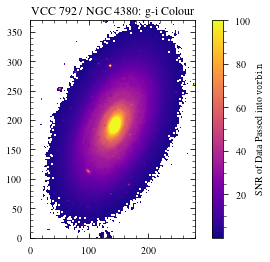

Bin-accretion...
1  /  9926
2  /  9926
3  /  9926
4  /  9926
5  /  9926
6  /  9926
7  /  9926
8  /  9926
9  /  9926
10  /  9926
11  /  9926
12  /  9926
13  /  9926
14  /  9926
15  /  9926
16  /  9926
17  /  9926
18  /  9926
19  /  9926
20  /  9926
21  /  9926
22  /  9926
23  /  9926
24  /  9926
25  /  9926
26  /  9926
27  /  9926
28  /  9926
29  /  9926
30  /  9926
31  /  9926
32  /  9926
33  /  9926
34  /  9926
35  /  9926
36  /  9926
37  /  9926
38  /  9926
39  /  9926
40  /  9926
41  /  9926
42  /  9926
43  /  9926
44  /  9926
45  /  9926
46  /  9926
47  /  9926
48  /  9926
49  /  9926
50  /  9926
51  /  9926
52  /  9926
53  /  9926
54  /  9926
55  /  9926
56  /  9926
57  /  9926
58  /  9926
59  /  9926
60  /  9926
61  /  9926
62  /  9926
63  /  9926
64  /  9926
65  /  9926
66  /  9926
67  /  9926
68  /  9926
69  /  9926
70  /  9926
71  /  9926
72  /  9926
73  /  9926
74  /  9926
75  /  9926
76  /  9926
77  /  9926
78  /  9926
79  /  9926
80  /  9926
81  /  9926
82  /  9926
83  /  9

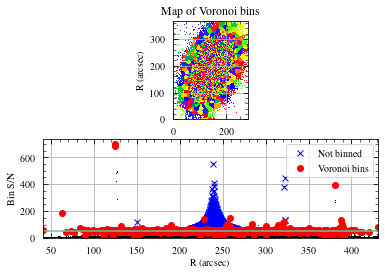

In [7]:
%matplotlib inline
gi_colour = -2.5 * np.log10(data_g_cut / data_i_cut)
gi_colour_err = calc_colour_err(data_g_cut, data_i_cut, noise_g_cut, noise_i_cut)
# 
# Preliminary binning
#
block_size = (4, 4)
gi_colour = block_reduce(gi_colour, block_size=block_size)
gi_colour_err = block_reduce(gi_colour_err, block_size=block_size)
# 
# Generate pixel coordinates (needed for vorbin)
# 
y_coords, x_coords = np.meshgrid(
    np.arange(gi_colour.shape[0]), np.arange(gi_colour.shape[1])
)
x_coords, y_coords = x_coords.T, y_coords.T
is_good = np.isfinite(gi_colour_err) & np.isfinite(gi_colour)
# 
# Printing some info
# 
print("array shapes:",
      x_coords.shape, y_coords.shape, gi_colour.shape, gi_colour_err.shape)
print("sum bad:", np.sum(~is_good))
# 
# Plot data passed into voronoi_2d_binning()
# 
gi_snr = abs(np.ma.masked_where(~is_good, gi_colour / gi_colour_err))
cmap = "plasma"
cmap = mpl.cm.get_cmap(cmap)
#
# fig, ax = plt.subplots(subplot_kw={"projection": wcs_i_cut})  # auto-sets origin="lower"
fig, ax = plt.subplots()
# img = ax.scatter(
#     x_coords.flatten(), y_coords.flatten(), c=(gi_colour/gi_colour_err), cmap=cmap, s=1
# )
img = ax.imshow(gi_snr, cmap=cmap, origin="lower", vmax=90) 
# img = ax.imshow(gi_colour, cmap=cmap, vmin=0.5, vmax=1.6)
# img = ax.imshow(gi_colour_err, cmap=cmap, vmax=np.percentile(gi_colour_err[is_good], 15))
# utils.add_scalebar(ax, wcs_i_cut, vcc792_dist,
#                    scalebar_factor=2, label="2 kpc", color="w", loc="lower right")
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
# cbar.set_label("g-i Colour Index")
# cbar.set_label("SNR (g-i colour / error)")
cbar.set_label("SNR of Data Passed into \\texttt{vorbin}")
#
# Overplot CO contours from VERTICO data
#
# ax.contour(data_co, transform=ax.get_transform(WCS(header_co)), levels=0, colors='w')
# 
# ax.tick_params(which="both", direction="out")
# ax.set_xlabel("RA (J2000)")
# ax.set_ylabel("Dec (J2000)")
ax.set_title("VCC 792 / NGC 4380: g-i Colour")
ax.grid(False)
ax.set_aspect("equal")
# fig.savefig("imgs/vcc792_g-i_binned_4x4.pdf")
plt.show()
# 
# ! LARGE IMAGE! Voronoi binning takes a long time. See method docstring
#
gi_binNum, gi_xNode, gi_yNode, gi_xBar, gi_yBar, gi_sn, gi_nPixels, gi_scale = voronoi_2d_binning(
    x_coords[is_good],
    y_coords[is_good],
    gi_colour[is_good],
    gi_colour_err[is_good],
    targetSN=50,
    pixelsize=1,
    cvt=False,
    quiet=False,
    wvt=False,
    sn_func=optimal_sn,
)


In [14]:
gi_binNum.max()

13612

## u-band


x_coords, y_coords, signal_binned, noise_binned shapes: (370, 281) (370, 281) (370, 281) (370, 281)
total bad elements: 0


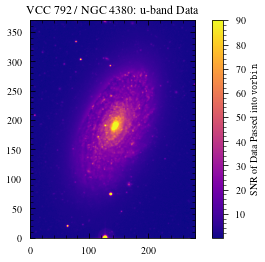

In [11]:
%matplotlib inline
# 
# Preliminary binning
#
# 2 x 2 binning: ~2120 seconds (> 35 min!), 4 x 4 binning: ~ 111 seconds
data_u_cut_binned, noise_u_cut_binned, x_coords_u, y_coords_u, is_good_u = prelim_bin(
    data_u_cut, noise_u_cut, block_size=(4, 4), print_info=True
)
# 
# Plot data passed into voronoi_2d_binning()
# 
u_snr = abs(np.ma.masked_where(~is_good_u, data_u_cut_binned / noise_u_cut_binned))
cmap = "plasma"
cmap = mpl.cm.get_cmap(cmap)
#
fig, ax = plt.subplots()
img = ax.imshow(u_snr, cmap=cmap, origin="lower", vmax=90) 
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label("SNR of Data Passed into \\texttt{vorbin}")
ax.set_title("VCC 792 / NGC 4380: u-band Data")
ax.grid(False)
ax.set_aspect("equal")
fig.savefig("imgs/vcc792_u_binned_4x4.pdf")
plt.show()
# 
# Voronoi binning
#
u_binNum, u_xNode, u_yNode, u_xBar, u_yBar, u_sn, u_nPixels, u_scale = voronoi_2d_binning(
    x_coords_u[is_good_u],
    y_coords_u[is_good_u],
    data_u_cut_binned[is_good_u],
    noise_u_cut_binned[is_good_u],
    targetSN=50,
    pixelsize=1,
    cvt=False,
    quiet=False,
    wvt=False,
    sn_func=None,
)


In [8]:
plt.close("all")

# Binning to VERTICO Nyquist Resolution


In [34]:
# 
# Load data
# 
vcc792_dist = 16.5 * u.Mpc
# Signal
iband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits"
gband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits"
uband_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits"
# Noise (sigma maps)
inoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits"
gnoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_6905_10184.fits"
unoise_path = "/arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.sig.3136_8588_6905_10184.fits"
# 
# Load NGVS data
# 
# Signal
data_i, header_i = utils.load_img(iband_path)
data_g, header_g = utils.load_img(gband_path)
data_u, header_u = utils.load_img(uband_path)
# Noise
noise_i, header_noise_i = utils.load_img(inoise_path)
noise_g, header_noise_g = utils.load_img(gnoise_path)
noise_u, header_noise_u = utils.load_img(unoise_path)
# 
# Cut out galaxy
# 
# vcc792_center = (2716, 1613)
# vcc792_shape = (1480, 1127)
# data_i_cut, wcs_i_cut = utils.cutout(data_i, vcc792_center, vcc792_shape, header=header_i)
# data_g_cut, wcs_g_cut = utils.cutout(data_g, vcc792_center, vcc792_shape, header=header_g)
# data_u_cut, wcs_u_cut = utils.cutout(data_u, vcc792_center, vcc792_shape, header=header_u)
# noise_i_cut, wcs_noise_i_cut = utils.cutout(noise_i, vcc792_center, vcc792_shape, header=header_noise_i)
# noise_g_cut, wcs_noise_g_cut = utils.cutout(noise_g, vcc792_center, vcc792_shape, header=header_noise_g)
# noise_u_cut, wcs_noise_u_cut = utils.cutout(noise_u, vcc792_center, vcc792_shape, header=header_noise_u)
# 
# VERTICO CO Data
# 
# co_path = "/arc/projects/vertico/products/release.v1.2/native/NGC4380/NGC4380_7m+tp_co21_pbcorr_round_k_mom0_Msun.fits"
co_path = "/arc/projects/vertico/products/release.v1.2/nyquistPix/9arcsec/NGC4380/NGC4380_7m+tp_co21_pbcorr_round_k_nyquistPix_9_arcsec_mom0_Msun.fits"
data_co, header_co = utils.load_img(co_path)
wcs_co = WCS(header_co)

Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      52   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.u.Mg004.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      58   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.i.Mg004.sig.3136_8588_6905_10184.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      22   (5453, 3280)   float32   
Filename: /arc/home/IsaacCheng/coop_f2021/ngvs_data/NGVS-2-2.l.g.Mg004.sig.3136_8588_690

In [5]:
# 
# Binning NGVS to CO Nyquist resolution. Not "apples to apples"
# 
%matplotlib widget
plt.close("all")
# 
# u-band data
# 
u_snr = abs(data_u / noise_u)
fig, ax = plt.subplots(subplot_kw={"projection": WCS(header_u)})
img = ax.imshow(u_snr, cmap="plasma", origin="lower", vmin=0, vmax=90) 
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label("SNR of u-Band Data")
ax.contour(data_co, transform=ax.get_transform(WCS(header_co)), levels=0, colors='w')
ax.set_title("VCC 792 / NGC 4380: u-band Data")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
plt.show()
# 
# CO Nyquist-sampled data
# 
data_co_masked = np.ma.masked_where(data_co <= 0, data_co)
fig, ax = plt.subplots(subplot_kw={"projection": WCS(header_co)})
img = ax.contourf(data_co_masked, levels=15, cmap="magma_r", vmin=0)
# img = ax.imshow(data_co_masked, cmap="magma_r", vmin=0)
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label(r"Surface Density ($\rm M_\odot\; pc^{-2}$)")
ax.set_title("VCC 792 / NGC 4380: Nyquist-sampled CO Data")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
plt.show()
# 
# Print stats
# TODO: Clean up this junk!
# 
# ? Don't know if I am passing the arguments in the right order.
# ? Luckily data_co is symmetric: (42, 42)
print("wcs_co", WCS(header_co))
co_bottomleft = WCS(header_co).pixel_to_world(0, 0)
co_topright = WCS(header_co).pixel_to_world(*data_co.shape)
co_centre = WCS(header_co).pixel_to_world(data_co.shape[1] // 2, data_co.shape[0] // 2)
# print(co_centre)
# print(WCS(header_u).world_to_pixel(co_bottomleft))
# print(WCS(header_u).world_to_pixel(co_topright))
# print(WCS(header_u).world_to_pixel(co_centre))
u_centre_of_co = WCS(header_u).world_to_pixel(co_centre)
u_bottomleft_of_co = WCS(header_u).world_to_pixel(co_bottomleft)
u_topright_of_co = WCS(header_u).world_to_pixel(co_topright)
u_to_co_factor = np.subtract(u_topright_of_co, u_bottomleft_of_co)
u_to_co_factor = np.ceil(np.divide(u_to_co_factor, data_co.shape)).astype(int)
u_shape_of_co = u_to_co_factor * data_co.shape
# print(u_to_co_factor)
# print("u_shape_of_co", u_shape_of_co)
# print(WCS(header_u).pixel_to_world(*u_centre_of_co))
# 
# Cut data
# 
data_u_cut, wcs_u_cut = utils.cutout(data_u, co_centre, u_shape_of_co, header=header_u)
noise_u_cut, wcs_noise_u_cut = utils.cutout(noise_u, co_centre, u_shape_of_co, header=header_noise_u)
u_snr_cut = abs(data_u_cut / noise_u_cut)
fig, ax = plt.subplots(subplot_kw={"projection": wcs_u_cut})
img = ax.imshow(u_snr_cut, cmap="plasma", origin="lower", vmin=0, vmax=90) 
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label("SNR of u-Band Data")
ax.contour(data_co, transform=ax.get_transform(WCS(header_co)), levels=0, colors='w')
ax.set_title("VCC 792 / NGC 4380: u-band Data Cut")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
plt.show()
# 
# Bin to VERTICO resolution
#
data_u_binned, noise_u_binned, x_coords, y_coords, is_good = prelim_bin(
    data_u_cut, noise_u_cut, block_size=u_to_co_factor
)
# * FIXME: Update WCS 
# ? Not sure if slice argument order is correct. Good thing it is symmetric here...
# https://docs.astropy.org/en/stable/api/astropy.wcs.WCS.html#astropy.wcs.WCS.slice
wcs_u_binned = wcs_u_cut.slice(
    (np.s_[::u_to_co_factor[0]], np.s_[::u_to_co_factor[1]])
)
wcs_u_binned.wcs.crpix = np.round(wcs_u_cut.wcs.crpix / u_to_co_factor)
wcs_u_binned.wcs.cd = wcs_u_cut.wcs.cd * u_to_co_factor
print("wcs_u_cut", wcs_u_cut)
print()
print("wcs_u_binned", wcs_u_binned)
# Plot
u_snr_binned = abs(data_u_binned / noise_u_binned)
fig, ax = plt.subplots(subplot_kw={"projection": wcs_u_binned})
# fig, ax = plt.subplots(subplot_kw={"projection": WCS(header_co)})  # not entirely correct
img = ax.imshow(u_snr_binned, cmap="plasma", origin="lower", vmin=150, vmax=1250) 
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label("SNR of u-Band Data")
ax.contour(data_co, transform=ax.get_transform(WCS(header_co)), levels=0, colors='w')
ax.set_title("VCC 792 / NGC 4380: u-band Data Binned")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

wcs_co WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 186.3430641667  10.01666666667  
CRPIX : 21.125  21.625  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.001111111111111  0.001111111111111  
NAXIS : 42  42


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

x_coords, y_coords, signal_binned, noise_binned shapes: (42, 42) (42, 42) (42, 42) (42, 42)
total bad elements: 0
wcs_u_cut WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 186.118063  10.10978557  
CRPIX : 4737.0  2257.0  
CD1_1 CD1_2  : -5.160914588e-05  0.0  
CD2_1 CD2_2  : 0.0  5.160914588e-05  
NAXIS : 924  924

wcs_u_binned WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---TAN'  'DEC--TAN'  
CRVAL : 186.118063  10.10978557  
CRPIX : 215.0  103.0  
CD1_1 CD1_2  : -0.0011354012093600001  0.0  
CD2_1 CD2_2  : 0.0  0.0011354012093600001  
NAXIS : 42  42


/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/wcs/wcs.py:3115: RuntimeWarning: cdelt will be ignored since cd is present
  cdelt = self.wcs.cdelt[wcs_index]
/arc/home/IsaacCheng/.local/lib/python3.8/site-packages/astropy/wcs/wcs.py:3124: RuntimeWarning: cdelt will be ignored since cd is present
  wcs_new.wcs.cdelt[wcs_index] = cdelt * iview.step


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [42]:
# 
# Binning NGVS to CO Nyquist resolution with reproject
# ! BIG FAIL !
# 
%matplotlib widget
plt.close("all")
# 
# u-band data
# 
u_snr = abs(data_u / noise_u)
fig, ax = plt.subplots(subplot_kw={"projection": WCS(header_u)})
img = ax.imshow(u_snr, cmap="plasma", origin="lower", vmin=0, vmax=90) 
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label("SNR of u-Band Data")
ax.contour(data_co, transform=ax.get_transform(WCS(header_co)), levels=0, colors='w')
ax.set_title("VCC 792 / NGC 4380: u-band Data")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
plt.show()
# 
# CO Nyquist-sampled data
# 
data_co_masked = np.ma.masked_where(data_co <= 0, data_co)
fig, ax = plt.subplots(subplot_kw={"projection": WCS(header_co)})
img = ax.contourf(data_co_masked, levels=15, cmap="magma_r", vmin=0)
# img = ax.imshow(data_co_masked, cmap="magma_r", vmin=0)
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label(r"Surface Density ($\rm M_\odot\; pc^{-2}$)")
ax.set_title("VCC 792 / NGC 4380: Nyquist-sampled CO Data")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
plt.show()
# 
# Print stats
# TODO: Clean up this junk!
# 
# ? Don't know if I am passing the arguments in the right order.
# ? Luckily data_co is symmetric: (42, 42)
print("wcs_co", wcs_co)
co_bottomleft = wcs_co.pixel_to_world(0, 0)
co_topright = wcs_co.pixel_to_world(*data_co.shape)
co_centre = wcs_co.pixel_to_world(data_co.shape[1] // 2, data_co.shape[0] // 2)
# print(co_centre)
# print(WCS(header_u).world_to_pixel(co_bottomleft))
# print(WCS(header_u).world_to_pixel(co_topright))
# print(WCS(header_u).world_to_pixel(co_centre))
u_centre_of_co = WCS(header_u).world_to_pixel(co_centre)
u_bottomleft_of_co = WCS(header_u).world_to_pixel(co_bottomleft)
u_topright_of_co = WCS(header_u).world_to_pixel(co_topright)
u_to_co_factor = np.subtract(u_topright_of_co, u_bottomleft_of_co)
u_to_co_factor = np.round(np.divide(u_to_co_factor, data_co.shape)).astype(int)
u_reproject_shape = u_to_co_factor * data_co.shape
print("u_to_co_factor:", u_to_co_factor)
print("u_reproject_shape", u_reproject_shape)
# print(WCS(header_u).pixel_to_world(*u_centre_of_co))
# 
# Reproject data
# 
u_data_reproj = reproject_interp(
    (data_u, header_u), wcs_co, shape_out=u_reproject_shape, return_footprint=False
)
u_noise_reproj = reproject_interp(
    (noise_u, header_noise_u), wcs_co, shape_out=u_reproject_shape, return_footprint=False
)
print("u_data_reproj.shape", u_data_reproj.shape)
wcs_co_reproject = wcs_co.deepcopy()
# wcs_co_reproject.wcs.crval = np.round(wcs_co.wcs.crval * u_to_co_factor)
wcs_co_reproject.wcs.crpix = wcs_co.wcs.crpix * u_to_co_factor
wcs_co_reproject.wcs.cdelt = wcs_co.wcs.cdelt / u_to_co_factor
# wcs_co_reproject.wcs.pc = wcs_co.wcs.pc * u_to_co_factor
# print("SUB", type(wcs_co.array_shape))
# wcs_co_reproject.array_shape = np.multiply(wcs_co.array_shape, u_to_co_factor)
wcs_co_reproject.array_shape = u_reproject_shape  # simpler
print("wcs_co_reproject", wcs_co_reproject)
# 
u_snr_reproject = abs(u_data_reproj / u_noise_reproj)
# fig, ax = plt.subplots(subplot_kw={"projection": wcs_co_reproject})
fig, ax = plt.subplots()
img = ax.imshow(u_snr_reproject, cmap="plasma", origin="lower", vmin=0) 
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label("SNR of Reprojected u-Band Data")
# ax.contour(data_co, transform=ax.get_transform(WCS(header_co)), levels=0, colors='w')
ax.set_title("VCC 792 / NGC 4380: u-band Reprojected Data")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
plt.show()
# 
# Bin to VERTICO resolution
# #
# data_u_binned, noise_u_binned, x_coords, y_coords, is_good = prelim_bin(
#     data_u_cut, noise_u_cut, block_size=u_to_co_factor
# )
# # * FIXME: Update WCS 
# # ? Not sure if slice argument order is correct. Good thing it is symmetric here...
# wcs_u_binned = wcs_u_cut.slice(
#     (np.s_[::u_to_co_factor[0]], np.s_[::u_to_co_factor[1]])
# )
# wcs_u_binned.wcs.crpix = np.round(wcs_u_cut.wcs.crpix / u_to_co_factor)
# wcs_u_binned.wcs.cd = wcs_u_cut.wcs.cd * u_to_co_factor
# print("wcs_u_cut", wcs_u_cut)
# print()
# print("wcs_u_binned", wcs_u_binned)
# # Plot
# u_snr_binned = abs(data_u_binned / noise_u_binned)
# fig, ax = plt.subplots(subplot_kw={"projection": wcs_u_binned})
# img = ax.imshow(u_snr_binned, cmap="plasma", origin="lower", vmin=150, vmax=1250) 
# cbar = fig.colorbar(img)
# cbar.ax.tick_params(which="both", direction="out")
# cbar.set_label("SNR of u-Band Data")
# ax.contour(data_co, transform=ax.get_transform(WCS(header_co)), levels=0, colors='w')
# ax.set_title("VCC 792 / NGC 4380: u-band Data Binned")
# ax.set_xlabel("RA (J2000)")
# ax.set_ylabel("Dec (J2000)")
# ax.grid(False)
# ax.set_aspect("equal")
# plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

wcs_co WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 186.3430641667  10.01666666667  
CRPIX : 21.125  21.625  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -0.001111111111111  0.001111111111111  
NAXIS : 42  42
u_to_co_factor: [22 22]
u_reproject_shape [924 924]


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


u_data_reproj.shape (120, 120)
wcs_co_reproject WCS Keywords

Number of WCS axes: 2
CTYPE : 'RA---SIN'  'DEC--SIN'  
CRVAL : 186.3430641667  10.01666666667  
CRPIX : 464.75  475.75  
PC1_1 PC1_2  : 1.0  0.0  
PC2_1 PC2_2  : 0.0  1.0  
CDELT : -5.050505050504546e-05  5.050505050504546e-05  
NAXIS : 924  924


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [28]:
plt.close("all")
# Reproject u-band data to CO data
u_data_reproj, u_data_footprint = reproject_exact(
    (data_u, header_u), header_co, parallel=4
)
u_noise_reproj, u_noise_footprint = reproject_exact(
    (noise_u, header_noise_u), header_co, parallel=4
)
u_snr_reproj = abs(u_data_reproj / u_noise_reproj)
# 
# Plot
# 
fig, (ax1, ax2) = plt.subplots(1, 2, subplot_kw={"projection": WCS(header_co)})
# 
img1 = ax1.imshow(u_snr_reproj, cmap="plasma", origin="lower", vmin=0, vmax=90)
# cbar1 = fig.colorbar(img1)
# cbar1.ax.tick_params(which="both", direction="out")
# cbar1.set_label("SNR of u-Band Data")
# Plot CO contours
ax1.contour(data_co, transform=ax1.get_transform(WCS(header_co)), levels=0, colors='w')
ax1.set_title("u-band Reprojected")
ax1.grid(False)
ax1.set_aspect("equal")
# 
ax2.imshow(u_data_footprint, origin='lower', vmin=0, vmax=1.5)
ax2.set_title("u-band Footprint")
ax2.coords['dec'].set_axislabel_position('r')
ax2.coords['dec'].set_ticklabel_position('r')
ax2.grid(False)
ax2.set_aspect("equal")
fig.suptitle("VCC 792 / NGC 4380")
plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]
the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [29]:
plt.close("all")
# 
# Reproject u-band data to CO data
# 
u_data_reproj, u_data_footprint = reproject_interp((data_u, header_u), header_co)
u_noise_reproj, u_noise_footprint = reproject_interp((noise_u, header_noise_u), header_co)
u_snr_reproj = abs(u_data_reproj / u_noise_reproj)
# 
# Plot
# 
fig, ax = plt.subplots(subplot_kw={"projection": WCS(header_co)})
img = ax.imshow(u_snr_reproj, cmap="plasma", origin="lower", vmin=0)
cbar = fig.colorbar(img)
cbar.ax.tick_params(which="both", direction="out")
cbar.set_label(r"SNR of \texttt{reproject\_interp()} u-Band Data")
ax.contour(
    data_co, transform=ax.get_transform(WCS(header_co)), levels=range(0, 15, 5), colors='w'
)
ax.set_title("VCC 792 / NGC 4380: u-band Data Reprojected")
ax.set_xlabel("RA (J2000)")
ax.set_ylabel("Dec (J2000)")
ax.grid(False)
ax.set_aspect("equal")
plt.show()

the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [30]:
print(u_data_reproj.shape)

(42, 42)
